# Assignment 1  

(For each question, run sequentially）

For windows system, you may need to change the data set path to "Datasets\\\\\[file_name\]"

## Question 1 Sampling

Python code for sampling

In [1]:
import numpy

In [2]:
def sampling(n):
    pairs = [(.2, "Movies"), (.4, "COMP-551"), (.1, "Playing"), (.3, "Studying")]
    probabilities = numpy.random.multinomial(n, list(zip(*pairs))[0])
    result = list(zip(probabilities, list(zip(*pairs))[1]))
    return result

Routine for 100 days

In [3]:
print(sampling(100))

[(18, 'Movies'), (33, 'COMP-551'), (19, 'Playing'), (30, 'Studying')]


In [4]:
print(sampling(1000))

[(185, 'Movies'), (405, 'COMP-551'), (111, 'Playing'), (299, 'Studying')]


## Question 2 Model Selection

Libraries used 

In [5]:
import numpy as np
import math
import csv
import sys
import matplotlib.pyplot as plt

The first step is to calculate the w matrix, based on training data set

In [6]:
M = 20

def calcW(trainSetPath):
    with open(trainSetPath) as csvFile:
        trainDataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []
        inputX_temp = []
        outputY_temp = []
        x0 = []   #x0 is just an array with 1s
        for row in trainDataSet:
            inputX_temp.append(float(row[0]))
            outputY_temp.append(float(row[1]))

        for i in range(len(inputX_temp)):  #add x0 to matrix
            x0.append(1.0)

    inputX.append(x0)

    for j in range(1, M+1, 1):
        inputX.append(np.power(inputX_temp, j))

    outputY.append(outputY_temp)
    inputX = np.transpose(np.array(inputX, dtype = 'float'))
    outputY = np.transpose(np.array(outputY, dtype = 'float'))
    part1 = np.dot(np.transpose(inputX), inputX)            # xTx
    part2 = np.dot(np.transpose(inputX), outputY)           # xTy

    w = np.dot(np.linalg.inv(part1), part2)                 # w = (xTx)^-1 dot xTy
    return w

Then we calculate training MSE and validation MSE

In [7]:
def calcMSE(dataSetPath, w):
    with open(dataSetPath) as csvFile:
        dataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []
        inputX_temp = []
        outputY_temp = []
        x0 = []   # x0 is just an array with 1
        for row in dataSet:
            inputX_temp.append(float(row[0]))
            outputY_temp.append(float(row[1]))

        for i in range(len(inputX_temp)):  # add x0 to matrix
            x0.append(1.0)

    inputX.append(x0)

    for j in range(1, M+1, 1):
        inputX.append(np.power(inputX_temp, j))

    outputY.append(outputY_temp)
    inputX = np.transpose(np.array(inputX, dtype = 'float'))
    outputY = np.transpose(np.array(outputY, dtype = 'float'))

    diff = np.subtract(np.dot(inputX, w), outputY)  # y(x, w) - y(x)
    MSE = np.square(diff).mean()
    return MSE

### 1.(a)

In [8]:
wMatrix = calcW("Datasets/Dataset_1_train.csv")
print("MSE for Training set (No regularization) = " + str(calcMSE("Datasets/Dataset_1_train.csv", wMatrix)))
print("MSE for Validation set (No regularization) = " + str(calcMSE("Datasets/Dataset_1_valid.csv", wMatrix)))

MSE for Training set (No regularization) = 6.474753981824253
MSE for Validation set (No regularization) = 1414.3778093802093


### 1.(b) Visualize the fit

By using w matraix we got before, we can calculate the model output

In [9]:
def calcModelOutput(x, wMatrix):
    y = 0.0
    for i in range(0, M+1, 1):
        y += math.pow(x, i) * wMatrix[i][0]
    return y

Plot function

In [10]:
def plotModel(dataSetPath, wMatrix):
    with open(dataSetPath) as csvFile:
        dataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []
        modelDataPoint = []

        for row in dataSet:
            inputX.append(float(row[0]))
            outputY.append(float(row[1]))

        for i in range(len(inputX)):
            modelDataPoint.append(calcModelOutput(inputX[i], wMatrix))

    plt.plot(sorted(inputX), sorted(modelDataPoint), 'b-', label='Model')
    plt.plot(inputX, outputY, 'ro', label="Data")
    plt.legend()
    plt.title("Fit Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

Make plot outputs appear and be stored within the notebook.

In [11]:
%matplotlib inline

Visualize the fit of validation dataset

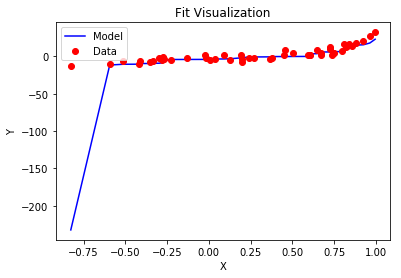

In [12]:
plotModel("Datasets/Dataset_1_valid.csv", wMatrix)

### 1.(c)
This model is overfitting because training MSE is much smaller than validation MSE

### 2.(a)
Following equation w = (x^Tx + λI)^(-1) dot (x^Ty)

In [13]:
def calcW_L2(dataSetPath, ld):
    with open(dataSetPath) as csvFile:
        dataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []
        inputX_temp = []
        outputY_temp = []
        x0 = []   # x0 is just an array with 1
        for row in dataSet:
            inputX_temp.append(float(row[0]))
            outputY_temp.append(float(row[1]))

        for i in range(len(inputX_temp)):  # add x0 to matrix
            x0.append(1.0)

    inputX.append(x0)

    for j in range(1, M+1, 1):
        inputX.append(np.power(inputX_temp, j))

    outputY.append(outputY_temp)
    inputX = np.transpose(np.array(inputX, dtype = 'float'))
    outputY = np.transpose(np.array(outputY, dtype = 'float'))

    part1 = np.dot(np.transpose(inputX), inputX)        # x^Tx
    part2 = ld * np.identity(part1.shape[0])            # λI
    left = np.linalg.inv(np.add(part1, part2))          # (x^Tx + λI)^(-1)
    right = np.dot(np.transpose(inputX), outputY)       # x^Ty

    wMatrix_L2 = np.dot(left, right)
    
    return wMatrix_L2

Helper function to print minimum MSE with corresponding λ

In [14]:
def printMinLambda(ld_set, valid_MSE):
    minLambda = 1
    minMSE = sys.float_info.max
    for i in range(len(valid_MSE)):
        minMSE = min(minMSE, valid_MSE[i])
        minLambda = ld_set[valid_MSE.index(minMSE)]
    print("Minimum MSE: " + str(minMSE) + "\n" + "Lambda : " + str(minLambda))

In [15]:
def pickLambda(trainDataSetPath, validDataSetPath):
    ld = 0.0
    ld_set = []
    train_MSE = []
    valid_MSE = []

    while (ld <= 1):
        wMatrix_L2 = calcW_L2(trainDataSetPath, ld)
        train_MSE.append(calcMSE(trainDataSetPath, wMatrix_L2))
        valid_MSE.append(calcMSE(validDataSetPath, wMatrix_L2))
        ld_set.append(ld)
        ld += 0.005

    printMinLambda(ld_set, valid_MSE)

# plot training MSE and validation MSE

    plt.plot(ld_set, train_MSE, 'r-', label = "Train MSE")
    plt.plot(ld_set, valid_MSE, 'b-', label = "Valid MSE")
    plt.legend()
    plt.axis([0, 1, 5, 15])
    plt.title("MSE VS Lambda")
    plt.xlabel("Lambda")
    plt.ylabel("MSE")
    plt.show()

Now we pick a value from a set of λ based on the validation performance, that is, with minimum MSE

Minimum MSE: 9.135098784694344
Lambda : 0.02


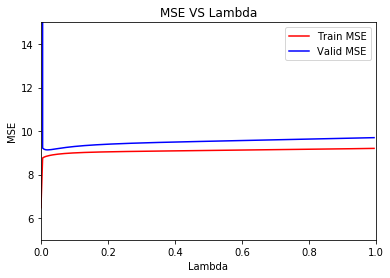

In [16]:
pickLambda("Datasets/Dataset_1_train.csv", "Datasets/Dataset_1_valid.csv")

The minimum MSE for validation is 9.135 and the corresponding λ is 0.02, we will use this value for our model

### 2.(b)
Now calculate the test MSE with λ = 0.02

In [17]:
wMatrix_L2 = calcW_L2("Datasets/Dataset_1_train.csv", 0.02)
print("MSE of Test data set (L2 regularization) : " + str(calcMSE("Datasets/Dataset_1_test.csv", wMatrix_L2)))

MSE of Test data set (L2 regularization) : 10.730218400927383


### 2.(c)
Visualize the fit of validation dataset with λ = 0.02

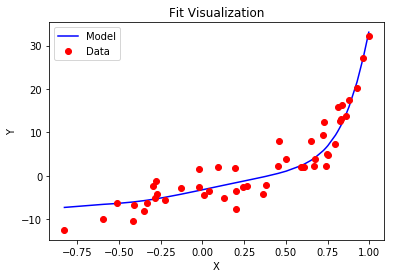

In [18]:
plotModel("Datasets/Dataset_1_valid.csv", wMatrix_L2)

Visualize the fit of test dataset with λ = 0.02

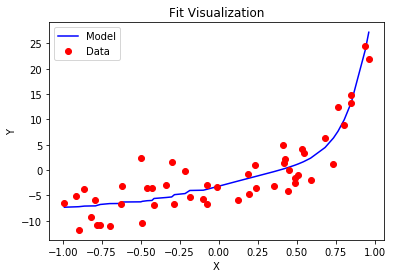

In [19]:
plotModel("Datasets/Dataset_1_test.csv", wMatrix_L2)

### 2.(d)
This model is not overfitting nor underfitting, because by using the λ we choose, the MSE of validation set and test set is really close.

## Question 3 Gradient Descent for Regression

Libraries used

In [20]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [21]:
stepSize = 1e-6

# Read training data setfrom CSV file
with open("Datasets/Dataset_2_train.csv") as csvFile:
    trainDataSet = csv.reader(csvFile, delimiter=',')
    inputX = []
    outputY = []
    xTemp = []
    x0 = []

    for row in trainDataSet:
        xTemp.append(float(row[0]))
        outputY.append(float(row[1]))
    for i in range(len(xTemp)):
        x0.append(1.0)

    inputX.append(xTemp)
    inputX.append(x0)
    inputX = np.transpose(np.array(inputX, dtype="float"))
    outputY = np.transpose(np.array(outputY, dtype="float"))

# Read validation data set from CSV file
with open("Datasets/Dataset_2_valid.csv") as csvFile:
    validDataSet = csv.reader(csvFile, delimiter=',')
    inputX2 = []
    outputY2 = []
    xTemp = []
    x0 = []

    for row in validDataSet:
        xTemp.append(float(row[0]))
        outputY2.append(float(row[1]))
    for i in range(len(xTemp)):
        x0.append(1.0)

    inputX2.append(xTemp)
    inputX2.append(x0)
    inputX2 = np.transpose(np.array(inputX2, dtype="float"))
    outputY2 = np.transpose(np.array(outputY2, dtype="float"))
    
# Read test data set from CSV file
with open("Datasets/Dataset_2_test.csv") as csvFile:
    validDataSet = csv.reader(csvFile, delimiter=',')
    inputX3 = []
    outputY3 = []
    xTemp = []
    x0 = []

    for row in validDataSet:
        xTemp.append(float(row[0]))
        outputY3.append(float(row[1]))
    for i in range(len(xTemp)):
        x0.append(1.0)

    inputX3.append(xTemp)
    inputX3.append(x0)
    inputX3 = np.transpose(np.array(inputX3, dtype="float"))
    outputY3 = np.transpose(np.array(outputY3, dtype="float"))

Based on several attempts, I found that after 10000 epoch, the MSE is stabilized, so I used 10000 epoch

In [22]:
trainMSE_set = []
validMSE_set = []
numEpoch = 10000

def calcMSE(x, y, w):
    diff = np.subtract(np.dot(x,w), y)
    MSE = np.square(diff).mean()
    return MSE

wMatrix = np.array([1.0, 1.0], dtype="float")

def calcW(epoch):
    w = np.array([1.0, 1.0], dtype="float")
    for i in range(epoch):
        for j in range(inputX.shape[0]):
            w[0] = w[0] - stepSize * ((w[1] + w[0] * inputX[j][0]) - outputY[j])
            w[1] = w[1] - stepSize * ((w[1] + w[0] * inputX[j][0]) - outputY[j]) * inputX[j][0]

        trainMSE_set.append(calcMSE(inputX, outputY, w))
        validMSE_set.append(calcMSE(inputX2, outputY2, w))

    return w

wMatrix  = calcW(numEpoch)

w0, w1 with step size 1e-6 and 10000 epoch

In [23]:
print("w0 is : " + str(wMatrix[0]) + "\n" + "w1 is : " + str(wMatrix[1]) + "\nwith " + str(numEpoch) + " epoch")

w0 is : 4.04628545461888
w1 is : 3.7751784300755262
with 10000 epoch


training MSE and validation MSE at 10000 epoch is

In [24]:
print(calcMSE(inputX, outputY, wMatrix))
print(calcMSE(inputX2, outputY2, wMatrix))

0.10867516072717355
0.09973526899206915


### 3.1
Plot the learning curve (training and validation MSE for every epoch)

In [25]:
def plotLearnCurve(trainMSE_set, validMSE_set, numEpoch):
    plt.plot(trainMSE_set, 'r', label = 'Train MSE')
    plt.plot(validMSE_set, 'b', label = 'Valid MSE')
    plt.legend()
    plt.axis([0, numEpoch, 0, 30])
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.show()

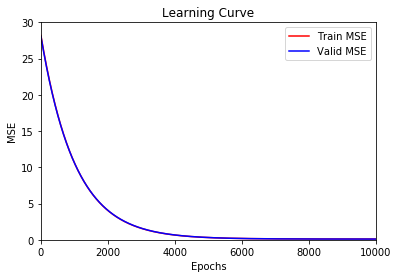

In [26]:
plotLearnCurve(trainMSE_set, validMSE_set, numEpoch)

### 3.2 Please see report for details

### 3.3

Plot learning process

In [27]:
def plotFitEvolve(w):
    with open("Datasets/Dataset_2_train.csv") as csvFile:
        trainDataSet = csv.reader(csvFile, delimiter=',')
        x = []
        y = []
        model_output = []

        for row in trainDataSet:
            x.append(float(row[0]))
            y.append(float(row[1]))

        for i in range(len(inputX)):
            model_output.append(w[1] + x[i] * w[0])


    plt.plot(x, model_output,'b',label="Train Data")
    plt.plot(x, y, 'ro', label="Train Data")
    plt.legend()
    plt.title("Learning Process")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

Visualize the training process, by setting epoch number from smaller value to largeer value

epoch number : 1400


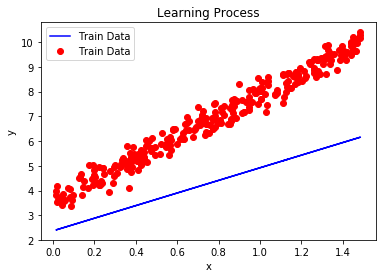

epoch number : 2800


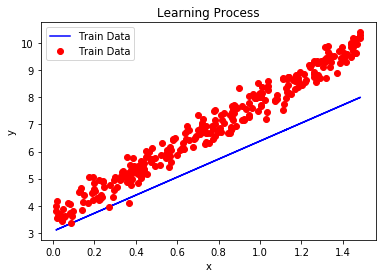

epoch number : 4200


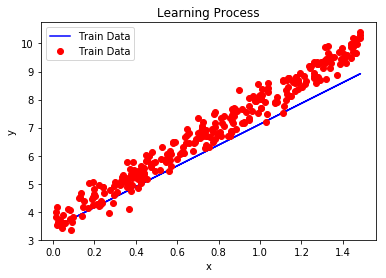

epoch number : 5600


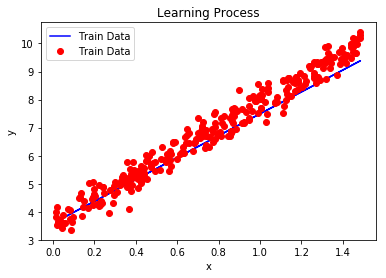

epoch number : 7000


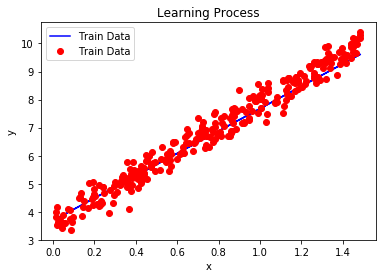

In [28]:
testW = np.array([1.0, 1.0], dtype="float")
for i in range (1, 6):
    epoch = i * 1400
    print("epoch number : " + str(epoch))
    testW = calcW(epoch)
    plotFitEvolve(testW)

We can see that as the training progresses, the fit gets better

## Question 4 Real life dataset

### 4.1

The following code will fill the missing data with sample mean and generate 10 different 80-20 splits files.
That is, 5 CandC-train files and 5 CandC-test files.

I commented the code out because running the code would re-fill the missing data and re-generate the splits files.
(The splits files are already generated and located under 'Datasets' directory)

In [29]:
# with open("Datasets/communities.csv") as csvFile:
#     trainDataSet = csv.reader(csvFile, delimiter=',')
#     data = []
#     for row in trainDataSet:
#         data.append(row)

# with open("Datasets/stat.csv") as csvFile:
#     trainDataSet = csv.reader(csvFile, delimiter=',')
#     stat = []
#     for row in trainDataSet:
#         stat.append(row)

# for i in range(len(data)):
#     for j in range(5, len(data[0])) : # The first five columns are non-predictive
#         if (data[i][j] == "?"):
#             data[i][j] = stat[j-5][3]

# # now we shuffle data and do 80-20 splits

# boundry = int(len(data)*0.8)

# for i in range(1, 6):
#     random.shuffle(data)
#     train_data = data[:boundry]
#     test_data = data[boundry:]

#     with open('Datasets/CandC-train' + str(i) + '.csv', 'w') as csvfile:
#         csvWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#         csvWriter.writerows(train_data)

#     with open('Datasets/CandC-test' + str(i) + '.csv', 'w') as csvfile:
#         csvWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#         csvWriter.writerows(test_data)

### 4.2

Calculate w parameter matrix by using train data

In [30]:
import numpy as np
import csv

def calcW(trainSetPath):
    with open(trainSetPath) as csvFile:
        trainDataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []

        for row in trainDataSet:
            inputX_temp = []
            inputX_temp.append(1.0)
            for i in range(5, len(row)-1):
                inputX_temp.append(float(row[i]))
            inputX.append(inputX_temp)
            outputY_temp = []
            outputY_temp.append(float(row[len(row)-1]))
            outputY.append(outputY_temp)

    inputX = np.array(inputX, dtype = 'float')
    outputY = np.array(outputY, dtype = 'float')
    part1 = np.dot(np.transpose(inputX), inputX)            # xTx
    part2 = np.dot(np.transpose(inputX), outputY)           # xTy

    w = np.dot(np.linalg.inv(part1), part2)                 # w = (xTx)^-1 dot xTy
    return w

Calculate MSE

In [31]:
def calcMSE(dataSetPath, w):
    with open(dataSetPath) as csvFile:
        dataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []

        for row in dataSet:
            inputX_temp = []
            inputX_temp.append(1.0)
            for i in range(5, len(row)-1):
                inputX_temp.append(float(row[i]))
            inputX.append(inputX_temp)
            outputY_temp = []
            outputY_temp.append(float(row[len(row)-1]))
            outputY.append(outputY_temp)

    inputX = np.array(inputX, dtype = 'float')
    outputY = np.array(outputY, dtype = 'float')
    diff = np.subtract(np.dot(inputX, w), outputY)  # y(x, w) - y(x)
    MSE = np.square(diff).mean()
    return MSE

Calculate MSEs of five different 80-20 splits and averaged MSE

In [32]:
wSet = []

sumMSE = 0.0

for i in range(1, 6):
    w = calcW('Datasets/CandC-train' + str(i) + '.csv')
    wSet.append(w)
    MSE = calcMSE('Datasets/CandC-test' + str(i) + '.csv', w)
    sumMSE += MSE
    print('The MSE of number ' + str(i) + " 80-20 split is " + str(MSE))

avgMSE = sumMSE/5.0
print("The MSE averaged over 5 different 80-20 splits is " + str(avgMSE))

#  Wirte average MSE and parameter table to file Assignment1_260561054_4_2 under current directory

# data = np.array(wSet)
# data = data.T
#
# # write average MSE
# with open('Assignment1_260561054_4_2', 'w') as f:
#     f.write("The MSE averaged over 5 different 80-20 splits is " + str(avgMSE) + '\n')
#     f.write('\n')
#     f.write('The parameters learnt for 5 different 80-20 splits are : \n')
#     f.write('\n')
#     for i in range(123):
#         for j in range(5):
#             f.write(str(data[0][i][j]))
#             f.write('\t')
#         f.write('\n')

The MSE of number 1 80-20 split is 0.02150754016362869
The MSE of number 2 80-20 split is 0.0215948287852376
The MSE of number 3 80-20 split is 0.016454247322346405
The MSE of number 4 80-20 split is 0.01751138505010865
The MSE of number 5 80-20 split is 0.019550013245980245
The MSE averaged over 5 different 80-20 splits is 0.01932360291346032


### 4.3

Apply Ridge-Regression and calculae average MSE for different values of λ.

Here I used 1e-10 < λ < 1e6

In [33]:
def calcW_Ridge(trainSetPath, ld):
    with open(trainSetPath) as csvFile:
        trainDataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []

        for row in trainDataSet:
            inputX_temp = []
            inputX_temp.append(1.0)
            for i in range(5, len(row)-1):
                inputX_temp.append(float(row[i]))
            inputX.append(inputX_temp)
            outputY_temp = []
            outputY_temp.append(float(row[len(row)-1]))
            outputY.append(outputY_temp)

    inputX = np.array(inputX, dtype = 'float')
    outputY = np.array(outputY, dtype = 'float')

    part1 = np.dot(np.transpose(inputX), inputX)        # x^Tx
    part2 = ld * np.identity(part1.shape[0])            # λI
    left = np.linalg.inv(np.add(part1, part2))          # (x^Tx + λI)^(-1)
    right = np.dot(np.transpose(inputX), outputY)       # x^Ty

    wMatrix_Ridge = np.dot(left, right)

    return wMatrix_Ridge

In [34]:
def pickLambda():
    ld = 1e-10
    ld_set = []
    MSE_avg = []

    while (ld <= 1e6):
        MSE_set = []
        for i in range(1, 6):
            w = calcW_Ridge('Datasets/CandC-train' + str(i) + '.csv', ld)
            MSE_set.append(calcMSE('Datasets/CandC-test' + str(i) + '.csv', w))
        MSE_avg.append(np.array(MSE_set, dtype='float').mean())
        ld_set.append(math.log10(ld))
        ld *= 10

    printMinLambda(ld_set, MSE_avg)

    plt.plot(ld_set, MSE_avg)
    plt.title("MSE VS λ")
    plt.xlabel("ln(λ)")
    plt.ylabel("Average MSE")
    plt.show()

def printMinLambda(ld_set, MSE_avg):
    minLambda = 0.0
    minMSE = sys.float_info.max
    for i in range(len(MSE_avg)):
        minMSE = min(minMSE, MSE_avg[i])
        minLambda = 10**ld_set[MSE_avg.index(minMSE)]
    print("Minimum averaged MSE: " + str(minMSE) + "\n" + "λ : " + str(minLambda))

Print the minimum averaged MSE along with it's corresponding λ

Minimum averaged MSE: 0.018555206975731275
λ : 1.0


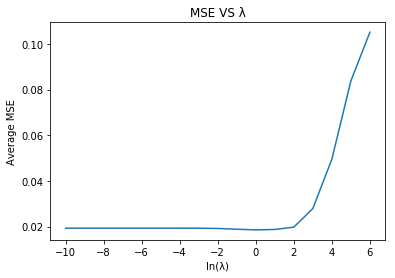

In [35]:
pickLambda()

We can see that λ = 1 gives the best fit, with average MSE = 0.018555206975731275

#### Feature Selection

We can perform the feature selection by removing the irrelevant features, that is, remove the features that have relative small weight.

First let's take averages for 5 different weights (parameters learnt) from 5 80-20 splits, sort the value and plot.

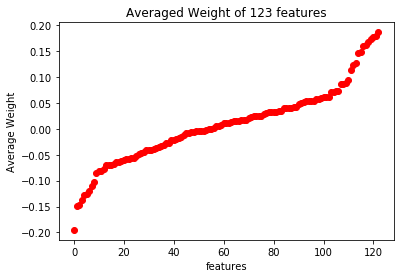

There are : 28 weights whose value is smaller than 0.02


In [36]:
wSet = []
for i in range(1, 6):
    w = calcW_Ridge('Datasets/CandC-train' + str(i) + '.csv', 1.0)
    wSet.append(w)

data = np.array(wSet)
data = data.T

w_avg = []
for i in range(123):
    sum = 0.0
    avg = 0.0
    for j in range(5):
        sum += data[0][i][j]
    avg = sum/5
    w_avg.append(avg)

plt.plot(sorted(w_avg), 'ro')
plt.title("Averaged Weight of 123 features")
plt.xlabel("features")
plt.ylabel("Average Weight")
plt.show()

w_filter = []
for i in range(len(w_avg)):
    if (abs(w_avg[i]) < 0.02):
        w_filter.append(w_avg[i])

print("There are : " + str(len(w_filter)) + " weights whose value is smaller than 0.02")

From the plot, we can see that the maximum and minimum of weight are around 0.2, thus we can try remove the features whose absolute average weight values are smaller than 0.02. And there are 28 features satisfying this condition.

The following code will re-calculate the learning parameters by cutting off the irrelevant features.

In [37]:
index_irre = []
for i in range(len(w_filter)):
    index_irre.append(w_avg.index(w_filter[i]))

In [38]:
def calcW_Ridge_FS(trainSetPath, ld, irre_features):
    with open(trainSetPath) as csvFile:
        trainDataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []

        for row in trainDataSet:
            inputX_temp = []
            inputX_temp.append(1.0)
            for i in range(5, len(row)-1):
                if (i in irre_features):
                    pass
                else:
                    inputX_temp.append(float(row[i]))
            inputX.append(inputX_temp)
            outputY_temp = []
            outputY_temp.append(float(row[len(row)-1]))
            outputY.append(outputY_temp)

    inputX = np.array(inputX, dtype = 'float')
    outputY = np.array(outputY, dtype = 'float')

    part1 = np.dot(np.transpose(inputX), inputX)        # x^Tx
    part2 = ld * np.identity(part1.shape[0])            # λI
    left = np.linalg.inv(np.add(part1, part2))          # (x^Tx + λI)^(-1)
    right = np.dot(np.transpose(inputX), outputY)       # x^Ty

    wMatrix_Ridge = np.dot(left, right)

    return wMatrix_Ridge

In [39]:
def calcMSE_FS(dataSetPath, w, irre_features):
    with open(dataSetPath) as csvFile:
        dataSet = csv.reader(csvFile, delimiter = ',')
        inputX = []
        outputY = []

        for row in dataSet:
            inputX_temp = []
            inputX_temp.append(1.0)
            for i in range(5, len(row)-1):
                if i in irre_features:
                    pass
                else:
                    inputX_temp.append(float(row[i]))
            inputX.append(inputX_temp)
            outputY_temp = []
            outputY_temp.append(float(row[len(row)-1]))
            outputY.append(outputY_temp)

    inputX = np.array(inputX, dtype = 'float')
    outputY = np.array(outputY, dtype = 'float')
    diff = np.subtract(np.dot(inputX, w), outputY)  # y(x, w) - y(x)
    MSE = np.square(diff).mean()
    return MSE

In [40]:
# Calculate MSEs and averaged MSE for 5 different 80-20 splits with reduced features
sumMSE = 0.0

for i in range(1, 6):
    w = calcW_Ridge_FS('Datasets/CandC-train' + str(i) + '.csv', 1.0, index_irre)
    MSE = calcMSE_FS('Datasets/CandC-test' + str(i) + '.csv', w, index_irre)
    sumMSE += MSE
    print('The MSE of number ' + str(i) + " 80-20 split after Feature Selection is " + str(MSE))

avgMSE = sumMSE/5.0
print("The MSE averaged over 5 different 80-20 splits after Feature Selection is " + str(avgMSE))

The MSE of number 1 80-20 split after Feature Selection is 0.021197538471147765
The MSE of number 2 80-20 split after Feature Selection is 0.021157681756650993
The MSE of number 3 80-20 split after Feature Selection is 0.01565585150559096
The MSE of number 4 80-20 split after Feature Selection is 0.016631568492580198
The MSE of number 5 80-20 split after Feature Selection is 0.01966550588669792
The MSE averaged over 5 different 80-20 splits after Feature Selection is 0.01886162922253357


The average MSE before Feature Selection is 0.018555206975731275

The average MSE after Feature Selection is 0.01886162922253357